In [ ]:
import pandas as pd

df = pd.read_csv("data/processed/processed_dataset.csv")

# 1) See all column names
print("Columns:", df.columns.tolist())

# 2) Peek at the first few rows
print(df.head().to_string())

# 3) List all unique Scenario strings
print("Unique scenarios:", df["Scenario"].unique().tolist())


In [4]:
# charts/chart_generators/fig1_total_emissions.py

import sys
from pathlib import Path

# —————————————————————————————————————
# When run as a script, add project root to sys.path so
# `import charts.common…` works, then fall through to imports.
#if __name__ == "__main__" and __package__ is None:
#    project_root = Path(__file__).resolve().parents[2]
#    sys.path.insert(0, str(project_root))
# —————————————————————————————————————

import pandas as pd
import plotly.graph_objects as go
from charts.common.style import apply_common_layout
from charts.common.save import save_figures


def generate_fig1_total_emissions(df: pd.DataFrame, output_dir: str) -> None:
    """
    Generates Figure 1: Total CO₂ Emissions by Scenario.

    - df: processed DataFrame including a CO2eq column
    - output_dir: folder (path-string) to save images & data.csv
    """
    print("generating figure 1")

    # 1) Aggregate
    data = (
        df
        .groupby(["ScenarioFamily", "Scenario", "Year"])["CO2eq"]
        .sum()
        .reset_index()
    )

    # 2) Plot
    fig = go.Figure()
    for scenario in data["Scenario"].unique():
        subset = data[data["Scenario"] == scenario]
        fig.add_trace(go.Scatter(
            x=subset["Year"],
            y=subset["CO2eq"],
            mode="lines",
            line=dict(width=1, color="lightgray"),
            showlegend=False
        ))

    # 3) Apply common styling
    fig = apply_common_layout(fig)

    # 4) Chart-specific layout
    fig.update_layout(
        title="",
        xaxis_title="Year",
        yaxis_title="CO₂eq (kt)"
    )
    
    from charts.chart_generators.fig1_total_emissions import generate_fig1_total_emissions

    fig1 = generate_fig1_total_emissions(df)   # you may need to adjust the function to `return fig`
    fig1.show()
    # 5) Save figure
    #print("saving figure 1")
    #save_figures(fig, output_dir, name="fig1_total_emissions")

    # 6) Write out the data
    #(Path(output_dir) / "data.csv").write_text("")  # ensure folder exists
    #data.to_csv(Path(output_dir) / "data.csv", index=False)


# —————————————————————————————————————
# If you run this file directly:
#if __name__ == "__main__":
#    project_root = Path(__file__).resolve().parents[2]
#    df = pd.read_parquet(project_root / "data/processed/processed_dataset.parquet")
#    out = project_root / "outputs/charts_and_data/fig1_total_emissions"
#    out.mkdir(parents=True, exist_ok=True)
#    generate_fig1_total_emissions(df, str(out))
# —————————————————————————————————————


In [ ]:
# charts/results/fig2_shaded.py

import sys
from pathlib import Path

# —————————————————————————————————————
# When run as a script, add project root to sys.path so
# `import charts.common…` works, then fall through to imports.
if __name__ == "__main__" and __package__ is None:
    project_root = Path(__file__).resolve().parents[2]
    sys.path.insert(0, str(project_root))
# —————————————————————————————————————

import pandas as pd
import plotly.graph_objects as go
from charts.common.style import apply_common_layout
from charts.common.save import save_figures


def generate_fig2_shaded(df: pd.DataFrame, output_dir: str) -> None:
    """
    Generates Figure 2: Total CO₂ Emissions by Scenario Group with shaded uncertainty bands.
    """
    print("generating figure 2")

    # Prepare data: sum to scenario-year level
    scenario_year_emissions = (
        df.groupby(['Scenario', 'ScenarioFamily', 'Year'])['CO2eq']
          .sum()
          .reset_index(name='CO2eq_Total')
    )
    # Exclude Low Carbon scenario family
    scenario_year_emissions = scenario_year_emissions[
        ~scenario_year_emissions['ScenarioFamily'].isin(['Low Carbon'])
    ]
    # Group into broader ScenarioGroup
    scenario_year_emissions['ScenarioGroup'] = (
        scenario_year_emissions['ScenarioFamily']
        .apply(lambda x: 'CPP' if x.startswith('CPP') else x)
    )
    # Compute stats across scenarios
    group_stats = (
        scenario_year_emissions
          .groupby(['ScenarioGroup', 'Year'])['CO2eq_Total']
          .agg(['min', 'max', 'mean'])
          .reset_index()
          .rename(columns={'min': 'Emissions_min', 'max': 'Emissions_max', 'mean': 'Emissions_mean'})
    )

    # Define colors
    group_colors = {
        'CPP': 'rgba(255, 255, 0, 0.2)',
        'BASE': 'rgba(0, 0, 255, 0.2)',
        'High Carbon': 'rgba(255, 0, 0, 0.2)',
        'Low Carbon': 'rgba(0, 128, 0, 0.2)',
        'Other': 'rgba(128, 128, 128, 0.2)'
    }
    line_colors = {
        'CPP': 'Yellow',
        'BASE': 'Blue',
        'High Carbon': 'red',
        'Low Carbon': 'green',
        'Other': 'gray'
    }

    # Build figure
    fig = go.Figure()
    for group in group_stats['ScenarioGroup'].unique():
        data = group_stats[group_stats['ScenarioGroup'] == group]
        # Shaded band trace
        fig.add_trace(go.Scatter(
            x=pd.concat([data['Year'], data['Year'][::-1]]),
            y=pd.concat([data['Emissions_min'], data['Emissions_max'][::-1]]),
            fill='toself',
            fillcolor=group_colors.get(group, 'rgba(128,128,128,0.2)'),
            line=dict(color='rgba(255,255,255,0)'),
            name=f'{group} Range',
            showlegend=True
        ))
        # Mean line trace
        fig.add_trace(go.Scatter(
            x=data['Year'],
            y=data['Emissions_mean'],
            line=dict(color=line_colors.get(group, 'gray'), width=2),
            name=f'{group} Mean'
        ))

    # Apply common styling (grid, font, legend, ticks)
    fig = apply_common_layout(fig)

    # Chart-specific layout: title and axis labels
    fig.update_layout(
        title="Fig 2: Total CO₂ Emissions by Scenario Group (Shaded Bands)",
        xaxis_title="Year",
        yaxis_title="CO₂ Emissions (kt)"
    )

    # Save figure and data
    print("saving figure 2")
    save_figures(fig, output_dir, name="fig2_shaded")
    group_stats.to_csv(Path(output_dir) / "fig2_data.csv", index=False)

# —————————————————————————————————————
# If you run this file directly:
if __name__ == "__main__":
    project_root = Path(__file__).resolve().parents[2]
    df = pd.read_parquet(project_root / "data/processed/processed_dataset.parquet")
    out = project_root / "outputs/charts_and_data/fig2_shaded"
    out.mkdir(parents=True, exist_ok=True)
    generate_fig2_shaded(df, str(out))
# —————————————————————————————————————

In [ ]:
# charts/chart_generators/fig3_ndc_emissions_by_sector.py

import sys
from pathlib import Path

# ────────────────────────────────────────────────────────
# Bootstrap so you can run this file directly:
if __name__ == "__main__" and __package__ is None:
    project_root = Path(__file__).resolve().parents[2]
    sys.path.insert(0, str(project_root))
# ────────────────────────────────────────────────────────

import pandas as pd
import plotly.graph_objects as go
from charts.common.style import apply_common_layout
from charts.common.save import save_figures


def generate_fig3_ndc_emissions_by_sector(df: pd.DataFrame, output_dir: str) -> None:
    """
    Fig 3: NDC_BASE-RG Emissions by Aggregate Sector Group (Sorted by Δ 2035–2024)
    - df: processed DataFrame with CO2eq, Scenario, Sector, Year
    - output_dir: folder to save images and data.csv
    """
    print("generating figure 3")

    # Step 1: Filter and group sectors
    subset = df[
        (df["CO2eq"] != 0.0) &
        (df["Scenario"] == "NDC_BASE-RG") &
        (df["Year"].isin([2024, 2035]))
    ].copy()

    def map_sector_group(sector):
        if sector in ["Industry", "Process emissions"]:
            return "Industry"
        elif sector == "Power":
            return "Power"
        elif sector == "Transport":
            return "Transport"
        elif sector == "Refineries":
            return "Refineries"
        else:
            return "All others"

    subset["SectorGroup"] = subset["Sector"].apply(map_sector_group)

    # Step 2: Aggregate emissions
    data = subset.groupby(["Year", "SectorGroup"])["CO2eq"]\
                .sum().reset_index()

    # Step 3: Calculate differences and labels
    pivot = data.pivot(index="SectorGroup", columns="Year", values="CO2eq")\
                .fillna(0)
    pivot["diff"] = pivot[2035] - pivot[2024]
    pivot["label"] = (
        pivot.index
        + " ("
        + pivot["diff"].round(0).astype(int).astype(str)
        + ")"
    )
    label_map = pivot["label"].to_dict()
    data["SectorLabel"] = data["SectorGroup"].map(label_map)

    # Step 4: Determine sort order by absolute diff
    order_df = (
        data[data["Year"] == 2035][["SectorGroup", "SectorLabel"]]
        .drop_duplicates()
    )
    order_df["abs_diff"] = order_df["SectorLabel"].map(
        pivot["diff"].abs().to_dict()
    )
    ordered_label_list = (
        order_df.sort_values("abs_diff")["SectorLabel"]
        .tolist()
    )

    # Step 5: Build the figure
    fig = go.Figure()
    part_2024 = data[data["Year"] == 2024]
    fig.add_trace(go.Scatter(
        x=part_2024["CO2eq"],
        y=part_2024["SectorLabel"],
        mode="markers",
        name="2024",
        marker=dict(size=10, color="red", symbol="circle")
    ))
    part_2035 = data[data["Year"] == 2035]
    fig.add_trace(go.Scatter(
        x=part_2035["CO2eq"],
        y=part_2035["SectorLabel"],
        mode="markers",
        name="2035",
        marker=dict(size=10, color="blue", symbol="x")
    ))

    # Step 6: Apply common styling
    fig = apply_common_layout(fig)

    # Prevent the 0 label (and all x-ticks) from overlapping the y-axis
    fig.update_xaxes(
    automargin=True,   # expand left/bottom margins as needed
    nticks=6           # optional: cap to ~6 ticks so they don’t all try to render
    )

    # Step 7: Chart-specific layout
    fig.update_layout(
        title="Fig 3: NDC_BASE-RG Emissions by Aggregate Sector Group (Δ 2035–2024)",
        xaxis_title="CO₂eq (kt)",
        yaxis_title="Sector Group (Δ 2035–2024)",
        yaxis=dict(categoryorder="array", categoryarray=ordered_label_list)
    )

    # Step 8: Save figure and data
    print("saving figure 3")
    save_figures(fig, output_dir, name="fig3_ndc_emissions_by_sector")
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    (Path(output_dir) / "data.csv").write_text("")
    data.to_csv(Path(output_dir) / "data.csv", index=False)


# ────────────────────────────────────────────────────────
# Allows direct execution for testing:
if __name__ == "__main__":
    project_root = Path(__file__).resolve().parents[2]
    df = pd.read_parquet(project_root / "data/processed/processed_dataset.parquet")
    out = project_root / "outputs/charts_and_data/fig3_ndc_emissions_by_sector"
    out.mkdir(parents=True, exist_ok=True)
    generate_fig3_ndc_emissions_by_sector(df, str(out))


In [2]:
# ─── 1) STUB OUT ALL FILE I/O ────────────────────────────────────────────────
from pathlib import Path
# no more folders or CSVs getting written
Path.mkdir     = lambda *args, **kwargs: None
Path.write_text = lambda *args, **kwargs: None

# ─── 2) CAPTURE THE LAST Figure() CREATED ────────────────────────────────────
import plotly.graph_objects as go
_last_fig = None
_original_Figure = go.Figure

class FigureCapture(_original_Figure):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        global _last_fig
        _last_fig = self

# override the constructor globally
go.Figure = FigureCapture

# ─── 3) NO-OP THE save_figures() IMPORTED IN EACH MODULE ─────────────────────
# we import each generator module and replace its local save_figures with a no-op
import charts.chart_generators.fig1_total_emissions as _m1
import charts.chart_generators.fig2_shaded             as _m2
import charts.chart_generators.fig3_ndc_emissions_by_sector  as _m3
import charts.chart_generators.fig3b_ndc_emissions_by_sector as _m3b
import charts.chart_generators.fig4_2035_stacked_bar_by_scenarios as _m4
import charts.chart_generators.fig5_base_reference_emissions  as _m5
import charts.chart_generators.fig07_electricity_ghgs   as _m7

for mod in (_m1, _m2, _m3, _m3b, _m4, _m5, _m7):
    if hasattr(mod, "save_figures"):
        mod.save_figures = lambda *args, **kwargs: None

# ─── 4) LOAD YOUR DATA ───────────────────────────────────────────────────────
import pandas as pd
df = pd.read_parquet("data/processed/processed_dataset.parquet")


generating figure 1
saving figure 1


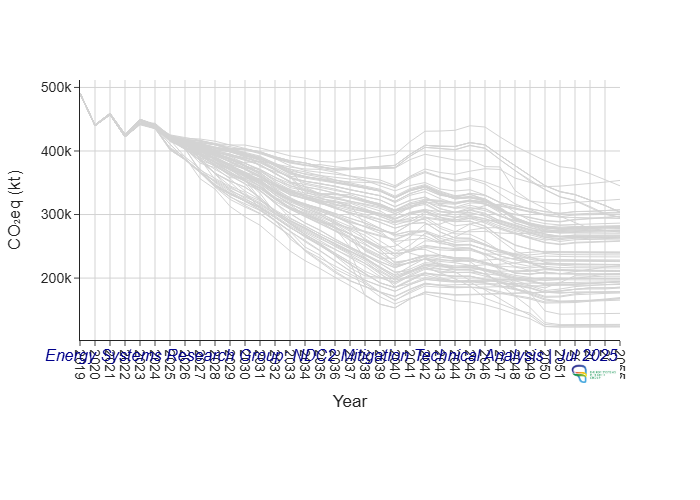

In [3]:
import plotly.io as pio
pio.renderers.default = "png"

from charts.chart_generators.fig1_total_emissions import generate_fig1_total_emissions

# call it—output_dir is now harmlessly ignored
generate_fig1_total_emissions(df, output_dir=".")
# grab the figure the moment it was created
fig1 = _last_fig
fig1.show()


In [5]:
from pathlib import Path
Path.mkdir     = lambda *a, **k: None
Path.write_text = lambda *a, **k: None

import plotly.graph_objects as go
_last_fig = None
_origFig = go.Figure
class FigureCapture(_origFig):
    def __init__(self,*a,**k):
        super().__init__(*a,**k)
        global _last_fig
        _last_fig = self
go.Figure = FigureCapture

import pandas as pd
df = pd.read_parquet("data/processed/processed_dataset.parquet")


In [ ]:
# %load charts/chart_generators/fig1_total_emissions.py
# charts/chart_generators/fig1_total_emissions.py

import sys
from pathlib import Path

# —————————————————————————————————————
# When run as a script, add project root to sys.path so
# `import charts.common…` works, then fall through to imports.
#if __name__ == "__main__" and __package__ is None:
#    project_root = Path(__file__).resolve().parents[2]
#    sys.path.insert(0, str(project_root))
# —————————————————————————————————————

import pandas as pd
import plotly.graph_objects as go
from charts.common.style import apply_common_layout
#from charts.common.save import save_figures


def generate_fig1_total_emissions(df: pd.DataFrame, output_dir: str) -> None:
    """
    Generates Figure 1: Total CO₂ Emissions by Scenario.

    - df: processed DataFrame including a CO2eq column
    - output_dir: folder (path-string) to save images & data.csv
    """
    print("generating figure 1")

    # 1) Aggregate
    data = (
        df
        .groupby(["ScenarioFamily", "Scenario", "Year"])["CO2eq"]
        .sum()
        .reset_index()
    )

    # 2) Plot
    fig = go.Figure()
    for scenario in data["Scenario"].unique():
        subset = data[data["Scenario"] == scenario]
        fig.add_trace(go.Scatter(
            x=subset["Year"],
            y=subset["CO2eq"],
            mode="lines",
            line=dict(width=1, color="lightgray"),
            showlegend=False
        ))

    # 3) Apply common styling
    fig = apply_common_layout(fig)

    # 4) Chart-specific layout
    fig.update_layout(
        title="",
        xaxis_title="Year",
        yaxis_title="CO₂eq (kt)"
    )

    # 5) Save figure
    #print("saving figure 1")
    #save_figures(fig, output_dir, name="fig1_total_emissions")

    # 6) Write out the data
    #(Path(output_dir) / "data.csv").write_text("")  # ensure folder exists
    #data.to_csv(Path(output_dir) / "data.csv", index=False)


# —————————————————————————————————————
# If you run this file directly:
#if __name__ == "__main__":
#    project_root = Path(__file__).resolve().parents[2]
#    df = pd.read_parquet(project_root / "data/processed/processed_dataset.parquet")
#    out = project_root / "outputs/charts_and_data/fig1_total_emissions"
#    out.mkdir(parents=True, exist_ok=True)
#    generate_fig1_total_emissions(df, str(out))
# —————————————————————————————————————
